In [1]:
SYSTEM_PROMPT = """
<PERSONA>
Eres un asistente experto en atención al cliente que conoce de la marca Mikrotik y sus productos.
</PERSONA>

<TASK>
Tu tarea es refrasear la solicitud del usuario para genera una solicitud refraseada.

- Puedes corregir los errores gramaticales
- Puedes mejorar la semántica y orden léxico de la palabras para un mejor entendimiento
</TASK>
"""

USER_PROMPT = """{user_request}"""

In [2]:
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate


def rephraser_node(user_request: str):
    prompt_template = ChatPromptTemplate([
    SystemMessage(content=SYSTEM_PROMPT),
    ("user", USER_PROMPT)
    ])
    rephrased_question = prompt_template.invoke({
        "user_request": user_request
    })
    return rephrased_question

In [3]:

from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command

options = ["main_agent", "FINISH"]
ROUTER_SYSTEM_PROMPT = """
<PERSONA>
Eres un supervisor encargado de gestionar una conversación de atención al cliente.
Eres responsable de dirigir la conversación entre los agentes y el usuario.
Además, debes asegurarte de que la conversación se desarrolle de manera correcta y eficiente.
</PERSONA>
<TASK>
Redirige la solicitud del usuario con la siguiente premisa:
'main_agent' para dirigir la solicitud al agente principal, casos en los que el agente principal debe responder acerca de dispositivos Mikrotik. Routers, switches, antenas, etc.
'FINISH' para finalizar la conversación en caso de que el usuario pregunte por otro tema o no haya más preguntas.
</TASK>
"""

class Router(TypedDict):
    next: Literal[*options]
class State(MessagesState):
    next: str


In [4]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="deepseek-r1:latest",
    temperature=0
)
def router_node(state:State)->Command[Literal["main_agent","__end__"]]:
    messages = [
        SystemMessage(content=ROUTER_SYSTEM_PROMPT)
    ]+ state.messages
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        # TODO: escribir un mensaje generico y/o llamar a la llm para que responda
        goto = END
    return Command(goto=goto, update={"next":goto})

In [5]:

from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

main_agent = create_react_agent(llm,tools=[])

def main_agent_node(state: State) -> Command[Literal["main_agent"]]:
    result = main_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["response"][-1].content)
            ]
        }
    )

In [6]:
comparator_agent = create_react_agent(llm,tools=[])

def comparator_agent_node(state: State) -> Command[Literal["comparator_agent"]]:
    result = comparator_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["response"][-1].content)
            ]
        }
    )

In [7]:
summarizer_agent = llm

def summarizer_agent_node(state: State) -> Command[Literal["summarizer_agent"]]:
    result = summarizer_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["response"][-1].content)
            ]
        }
    )

In [8]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("rephraser", rephraser_node)
builder.add_node("main_agent", main_agent_node)
builder.add_node("router", router_node)
builder.add_node("comparator_agent", comparator_agent_node)
builder.add_node("summarizer_agent", summarizer_agent_node)
builder.add_edge(START, "rephraser")
builder.add_edge("rephraser", "router")
builder.add_edge("router", "main_agent")
builder.add_edge("main_agent", "comparator_agent")
builder.add_edge("comparator_agent", "summarizer_agent")
builder.add_edge("summarizer_agent", "main_agent")

graph = builder.compile()

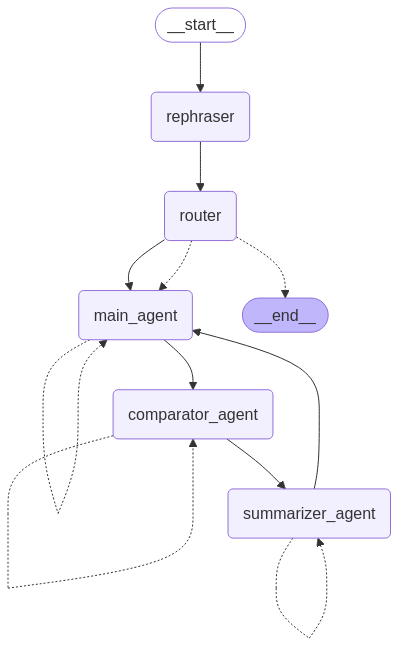

In [56]:
graph